## 準備

In [ ]:
# googleドライブのマウント
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
# 依存ライブラリのインストール
!git clone https://github.com/huggingface/transformers.git
!cd transformers
!pip install -qU ./transformers sentencepiece transformers[torch] datasets evaluate mecab-python3 unidic-lite

Cloning into 'transformers'...
remote: Enumerating objects: 178140, done.
remote: Counting objects: 100% (46507/46507), done.
remote: Compressing objects: 100% (2029/2029), done.
remote: Total 178140 (delta 45298), reused 44485 (delta 44477), pack-reused 131633
Receiving objects: 100% (178140/178140), 175.86 MiB | 30.29 MiB/s, done.
Resolving deltas: 100% (129642/129642), done.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 34.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# data: 学習用データセット格納用
# model: 学習済みモデル格納用
!mkdir -p data model

In [ ]:
# 事前学習済みモデル
PRETRAINED_MODEL_NAME = "rinna/japanese-gpt2-small"

# 転移学習済みモデル
MODEL_DIR = "model/final_output"

In [ ]:
from transformers import T5Tokenizer, AutoModelForCausalLM

# gpt2の事前学習済みトークナイズをロード
tokenizer = T5Tokenizer.from_pretrained(PRETRAINED_MODEL_NAME, is_fast=True)
# gpt2の事前学習済みモデルをロード
model = AutoModelForCausalLM.from_pretrained(PRETRAINED_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/282 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/806k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/153 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/454M [00:00<?, ?B/s]

## 専用トークンの追加

In [ ]:
print(f"トークン追加前: {len(tokenizer)=}, {len(tokenizer.all_special_tokens)=}")
print(tokenizer.all_special_tokens)

トークン追加前: len(tokenizer)=32000, len(tokenizer.all_special_tokens)=7
['<s>', '</s>', '<unk>', '[SEP]', '[PAD]', '[CLS]', '[MASK]']


In [ ]:
# 専用トークン追加
special_tokens = {
    "additional_special_tokens": ["<NEG_START>", "<POS_START>"]
}

tokenizer.add_special_tokens(special_tokens)
print(f"トークン追加後: {len(tokenizer)=}, {len(tokenizer.all_special_tokens)=}")
print(tokenizer.all_special_tokens)

トークン追加後: len(tokenizer)=32002, len(tokenizer.all_special_tokens)=9
['<s>', '</s>', '<unk>', '[SEP]', '[PAD]', '[CLS]', '[MASK]', '<NEG_START>', '<POS_START>']


In [ ]:
# トークナイザー保存
tokenizer.save_pretrained("reframing_tokenizer.pt")

# 追加した専用トークン用のembeddingsを用意
model.resize_token_embeddings(len(tokenizer))

# モデル保存
model.save_pretrained("model/reframing_model")

## データの準備

In [ ]:
import pandas as pd

# リフレーミングコーパスのロード
dir_path = "drive/MyDrive/ColabNotebooks/nallab/t5/"
excel_file_path = "drive/MyDrive/ColabNotebooks/nallab/corpus/reframing-corpus.xlsx"
sheet_name = "発話"
corpus_df = pd.read_excel(excel_file_path, sheet_name=sheet_name)
corpus_df

,No,ペルソナID,話者,トピック,発話
0,1,1,A,生活全般,最近同じ日常の繰り返しで、新しいことを始める勇気が出なくてモヤモヤしているんです。
1,1,1,B,生活全般,落ち着いた生活を送りながら新しいことを始めようとするあなたはチャレンジ精神が素晴らしいですね。
2,2,1,A,職場・学業,生徒たちにもっとわかりやすく教えたいのに、伝わってない気がして悔しいです。
3,2,1,B,職場・学業,あなたは生徒たちの理解を深く気にかけ、より良い指導を心がけている素晴らしい教師ですね。
4,3,1,A,家族・恋愛,両親にもっと近くに住みたいって言われるけど、自分の仕事や生活を考えると複雑なんです。
...,...,...,...,...,...
1995,998,250,B,職場・学業,好きなことを仕事にできていることはとても素敵なことですね。
1996,999,250,A,家族・恋愛,夫とは長い間一緒にいるけれど、最近は会話が少なくなってきて寂しいです。
1997,999,250,B,家族・恋愛,いつまでも旦那さんとの会話を大切にしているあなたは素敵な奥さんですね。
1998,1000,250,A,自己評価,自分は家族や仕事を大切にしてきたけど、それが十分だったのか疑問に思います。


In [ ]:
# 話者Aのネガティブ発話(偶数行)だけ取り出す
even_indices = corpus_df.index % 2 == 0
even_rows_df = corpus_df[even_indices].copy()

negative_texts = []
for i in range(len(even_rows_df)):
  negative_text = even_rows_df.iloc[i, 4]
  negative_texts.append(negative_text)

# 話者Bのポジティブ発話(奇数行)だけ取り出す
odd_indices = corpus_df.index % 2 != 0
odd_rows_df = corpus_df[odd_indices].copy()

positive_texts = []
for i in range(len(odd_rows_df)):
  positive_text = odd_rows_df.iloc[i, 4]
  positive_texts.append(positive_text)

In [ ]:
# データ整形
corpus_sentences = []
for sentence_i in range(len(even_rows_df)):
    data = '<NEG_START>' + negative_texts[sentence_i] + '<POS_START>' + positive_texts[sentence_i] + '</s>'
    corpus_sentences.append(data)

# ランダムにシャッフル
import random
random.shuffle(corpus_sentences)

# データを8:1:1の比率で分割
total_len = len(corpus_sentences)
split_index_1 = int(0.8 * total_len)
split_index_2 = split_index_1 + int(0.1 * total_len)

learning_data = corpus_sentences[:split_index_1]
validation_data = corpus_sentences[split_index_1:split_index_2]
test_data = corpus_sentences[split_index_2:]

# ラーニングデータの書き出し
with open('data/train.txt', 'w') as learning_data_file:
    learning_data_file.write('\n'.join(learning_data) + '\n')

# 検証データの書き出し
with open('data/val.txt', 'w') as validation_data_file:
    validation_data_file.write('\n'.join(validation_data) + '\n')

# テストデータの書き出し
with open('data/test.txt', 'w') as test_data_file:
    test_data_file.write('\n'.join(test_data) + '\n')

print(f"{len(learning_data)=}, {len(validation_data)=}, {len(test_data)=}")

len(learning_data)=800, len(validation_data)=100, len(test_data)=100


## ハイパーパラメータチューニング (対象：epoch数)

In [ ]:
import os
from sklearn.model_selection import KFold

with open("data/train.txt", "r") as f:
    lines = f.readlines()

# 交差検証の設定
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(lines), start=1):
    train_lines = [lines[i] for i in train_idx]
    val_lines = [lines[i] for i in val_idx]

    # 訓練データと検証データの保存先ディレクトリ
    train_val_dir = f"data/fold_{fold}"
    os.makedirs(train_val_dir, exist_ok=True)

    # 訓練データと検証データをテキストファイルとして保存
    train_file = f"data/fold_{fold}/train.txt"
    val_file = f"data/fold_{fold}/val.txt"
    with open(train_file, "w") as f:
        f.writelines(train_lines)
    with open(val_file, "w") as f:
        f.writelines(val_lines)

In [ ]:
tuning_epoch_output_path = "outputs/epochs"
if not os.path.exists(tuning_epoch_output_path):
    os.makedirs(tuning_epoch_output_path)

In [ ]:
import json
import os

# 初期エポック数
epochs = 1

overfitting_count = 0
patience = 1

average_train_losses = []
average_val_losses = []

while overfitting_count < patience:

    # 一時的にlossとaccuracyを記録
    train_losses = []
    val_losses = []

    for fold in range(1, 6):
        train_file = f"data/fold_{fold}/train.txt"
        val_file = f"data/fold_{fold}/val.txt"
        output_dir = f"{tuning_epoch_output_path}/{epochs}_output_fold_{fold}"

        # ファインチューニングを実行
        os.system(f"""
        python ./transformers/examples/pytorch/language-modeling/run_clm.py \
            --model_name_or_path='model/reframing_model' \
            --tokenizer_name='reframing_tokenizer.pt' \
            --train_file={train_file} \
            --validation_file={val_file} \
            --do_train \
            --do_eval \
            --num_train_epochs={epochs} \
            --save_steps=10000 \
            --save_total_limit=3 \
            --per_device_train_batch_size=1 \
            --per_device_eval_batch_size=1 \
            --use_fast_tokenizer=False \
            --output_dir={output_dir}
        """)
        print(f"Epochs: {epochs}, Fold: {fold}")

        # train_results.jsonからlossを取得してリストに追加
        with open(os.path.join(output_dir, "train_results.json")) as train_file, open(os.path.join(output_dir, "eval_results.json")) as val_file:
            train_results = json.load(train_file)
            val_results = json.load(val_file)
            train_loss = train_results["train_loss"]
            val_loss = val_results["eval_loss"]
            train_losses.append(train_loss)
            val_losses.append(val_loss)

    # 各エポック数ごとのlossの平均を計算
    avg_train_losses = sum(train_losses)/len(train_losses)
    avg_val_losses = sum(val_losses)/len(val_losses)
    print(f"Epochs: {epochs}, Average Train Loss: {avg_train_losses}, Average Validation Loss: {avg_val_losses}")

    # early-stopping
    # train_lossは下がったがeval_lossesが上がった場合
    if len(average_train_losses) > 1 and len(average_val_losses) > 1:
        if avg_train_losses < average_train_losses[-1] and avg_val_losses > average_val_losses[-1]:
            overfitting_count += 1

    average_train_losses.append(avg_train_losses)
    average_val_losses.append(avg_val_losses)

    # 一時記録用のリストを初期化
    train_losses.clear()
    val_losses.clear()

    epochs += 1

Epochs: 1, Fold: 1
Epochs: 1, Fold: 2
Epochs: 1, Fold: 3
Epochs: 1, Fold: 4
Epochs: 1, Fold: 5
Epochs: 1, Average Train Loss: 2.6986489068894155, Average Validation Loss: 2.309105968475342
Epochs: 2, Fold: 1
Epochs: 2, Fold: 2
Epochs: 2, Fold: 3
Epochs: 2, Fold: 4
Epochs: 2, Fold: 5
Epochs: 2, Average Train Loss: 2.256475103469122, Average Validation Loss: 1.8296225786209106
Epochs: 3, Fold: 1
Epochs: 3, Fold: 2
Epochs: 3, Fold: 3
Epochs: 3, Fold: 4
Epochs: 3, Fold: 5
Epochs: 3, Average Train Loss: 1.9817346239846851, Average Validation Loss: 1.6803311109542847
Epochs: 4, Fold: 1
Epochs: 4, Fold: 2
Epochs: 4, Fold: 3
Epochs: 4, Fold: 4
Epochs: 4, Fold: 5
Epochs: 4, Average Train Loss: 1.799665360223679, Average Validation Loss: 1.6073632478713988
Epochs: 5, Fold: 1
Epochs: 5, Fold: 2
Epochs: 5, Fold: 3
Epochs: 5, Fold: 4
Epochs: 5, Fold: 5
Epochs: 5, Average Train Loss: 1.6609653145926342, Average Validation Loss: 1.5667062997817993
Epochs: 6, Fold: 1
Epochs: 6, Fold: 2
Epochs: 6, Fold

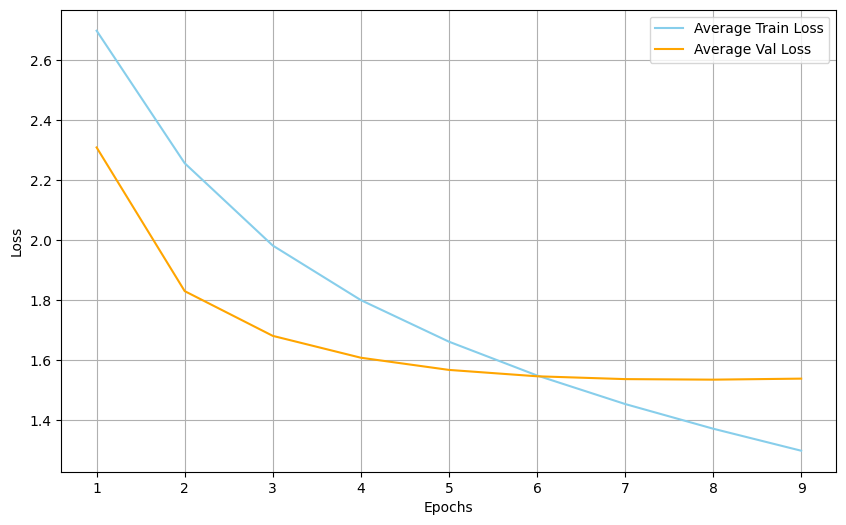

In [ ]:
import matplotlib.pyplot as plt

# 平均トレーニング損失とバリデーション損失のデータ
average_train_losses = [2.6986489068894155, 2.256475103469122, 1.9817346239846851,
                        1.799665360223679, 1.6609653145926342, 1.5482222057524182,
                        1.4529456313775508, 1.3705494835263206, 1.2970085830284803]
average_val_losses = [2.309105968475342, 1.8296225786209106, 1.6803311109542847,
                      1.6073632478713988, 1.5667062997817993, 1.545432162284851,
                      1.5359985828399658, 1.5341849088668824, 1.5375986099243164]

epochs = list(range(1, 10))

plt.figure(figsize=(10, 6))
plt.plot(epochs, average_train_losses, label='Average Train Loss', color='skyblue')
plt.plot(epochs, average_val_losses, label='Average Val Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## ファインチューニング

In [ ]:
# ファインチューニングを実行
!python ./transformers/examples/pytorch/language-modeling/run_clm.py \
    --model_name_or_path="model/reframing_model" \
    --tokenizer_name="reframing_tokenizer.pt" \
    --train_file="data/train.txt" \
    --validation_file="data/val.txt" \
    --do_train \
    --do_eval \
    --num_train_epochs=8 \
    --learning_rate=5e-05 \
    --save_steps=10000 \
    --save_total_limit=3 \
    --per_device_train_batch_size=1 \
    --per_device_eval_batch_size=1 \
    --overwrite_output_dir \
    --use_fast_tokenizer=False \
    --output_dir={MODEL_DIR}

2024-01-18 07:01:13.226796: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-18 07:01:13.226846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-18 07:01:13.228279: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-18 07:01:14.402250: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
CUDA backend failed to initialize: Found cuBLAS version 120103, but JAX was built against version 120205, which is newer. The copy of cuBLAS that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MI

## 評価実験

In [ ]:
from pathlib import Path
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# トークナイザーをロード
tokenizer_path = "reframing_tokenizer.pt"
tokenizer = T5Tokenizer.from_pretrained(tokenizer_path)
tokenizer.do_lower_case = True

# ファインチューニング済みモデルをロード
model = AutoModelForCausalLM.from_pretrained(MODEL_DIR)
model.to(device)
model.eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(32002, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=32002, bias=False)
)

In [ ]:
tokenizer_with_prefix_space = T5Tokenizer.from_pretrained(tokenizer_path, add_prefix_space=True)

# トークンIDを取得する関数
def get_tokens_as_list(word_list):
    tokens_list = []
    for word in word_list:
        tokenized_word = tokenizer_with_prefix_space([word], add_special_tokens=False).input_ids[0]
        tokens_list.append(tokenized_word)
    return tokens_list

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
bad_words_ids = get_tokens_as_list(word_list=["<s>", "</s>", "<unk>", "[SEP]", "[PAD]", "[CLS]", "[MASK]", "<POS_START>", "<NEG_START>", "...", "_", "|", ".", ":", ";", "{}", "{", "}", "()", "(", ")", "[]", "[", "]", '""', "codice", "太守"])

# 返答を生成する関数(ビームサーチ)
def generate_reply_beam(inp, num_gen=100):
    input_text = "<s>" + str(inp) + "[SEP]"
    input_ids = tokenizer.encode(input_text, return_tensors='pt', padding=True, truncation=True).to(device)

    num_beams = num_gen
    out = model.generate(input_ids, max_length=64, num_beams=num_beams,
                         num_return_sequences=num_gen, no_repeat_ngram_size=3,
                         bos_token_id=tokenizer.bos_token_id, eos_token_id=tokenizer.eos_token_id,
                         bad_words_ids=bad_words_ids)

    replies = []
    for sent in tokenizer.batch_decode(out):
        sent = sent.split('[SEP]</s>')[1]
        sent = sent.replace('</s>', '')
        sent = sent.replace('<br>', '\n')
        replies.append(sent.strip())

    # 生成確率が最も高い返答文
    top_reply = replies[0]

    return replies, top_reply

In [ ]:
def extract_parts(text):
    """ '<NEG_START>' から '<POS_START>' までと '<POS_START>' から '</s>' までの部分を抽出 """
    input_text = text.split("<POS_START>")[0].split("<NEG_START>")[1].strip()
    correct_reply = text.split("<POS_START>")[1].split("</s>")[0].strip()
    return input_text, correct_reply

In [ ]:
import MeCab
from nltk.translate.bleu_score import sentence_bleu

def tokenize_japanese(text):
    m = MeCab.Tagger("-Owakati")
    return m.parse(text).strip().split()

# BLEUを計算する関数
def calculate_bleu_score(reference, candidate):
    reference_tokenized = [tokenize_japanese(reference)]
    candidate_tokenized = tokenize_japanese(candidate)
    score = sentence_bleu(reference_tokenized, candidate_tokenized, weights=(0.5, 0.5))  # Bigrams
    return score

In [ ]:
import torch.nn.functional as F

# 生成確率の最も高い返答文のベクトル化する関数
def vectorization(top_reply):
  tokenized_top_reply = tokenizer(top_reply, return_tensors='pt', padding=True, truncation=True).to(device)
  # モデルを通して特徴ベクトルを生成
  with torch.inference_mode():
      outputs = model(**tokenized_top_reply, output_hidden_states=True)
      # 最後の隠れ層の状態を取得
      last_hidden_state = outputs.hidden_states[-1]
      # 平均プーリング
      top_reply_vector = last_hidden_state.mean(dim=1).to("cpu")
  # ベクトルをノルムが1になるよう正規化
  top_reply_vector = F.normalize(top_reply_vector, dim=1)
  torch.linalg.norm(top_reply_vector, dim=1)
  return top_reply_vector

In [ ]:
# 生成確率の最も高い返答文と正解返答文のコサイン類似度を計算する関数
def cosine_similarity(vec1, vec2):
    # ベクトルがノルム1に正規化されているため、ドット積を計算
    # vec1とvec2が2次元テンソルで1 x Nの形状の場合、それらを1次元に変換
    vec1 = vec1.squeeze()
    vec2 = vec2.squeeze()
    return torch.dot(vec1, vec2)

In [ ]:
def calculate_accuracy_beam(test_data):
    correct_count = 0
    total_mrr = 0
    total_bleu = 0
    total_similarity = 0
    max_bleu_scores = []
    max_similarity_scores = []
    correct_replies_dict = {}
    top_reply_dict = {}

    for index, data in enumerate(test_data):
        input_text, correct_reply = extract_parts(data)
        replies, top_reply = generate_reply_beam(input_text)
        top_reply_dict[index] = {"input_text": input_text, "top_reply": top_reply}

        max_bleu_score = 0
        max_similarity_score = 0

        # 正解データのベクトル化
        correct_reply_vector = vectorization(correct_reply)

        for reply in replies:
            # BLEUスコアの計算
            bleu_score = calculate_bleu_score(correct_reply, reply)
            max_bleu_score = max(max_bleu_score, bleu_score)

            # 返答文のベクトル化
            reply_vector = vectorization(reply)

            # コサイン類似度の計算
            similarity = cosine_similarity(correct_reply_vector, reply_vector)
            max_similarity_score = max(max_similarity_score, similarity)

        max_bleu_scores.append(max_bleu_score)
        max_similarity_scores.append(max_similarity_score)

        # 正解文が返答候補の中にあるか確認
        if correct_reply in replies:
            rank = replies.index(correct_reply) + 1
            correct_replies_dict[index] = {
                "rank": rank,
                "input_text": input_text,
                "correct_reply": correct_reply
            }
            correct_count += 1
            # MRRの計算
            total_mrr += 1 / rank

        # 最も生成確率が高い返答のBLEUスコアの計算
        bleu_score = calculate_bleu_score(correct_reply, top_reply)
        total_bleu += bleu_score

        # 生成確率の最も高い返答文のベクトル化
        top_reply_vector = vectorization(top_reply)

        # コサイン類似度の計算
        similarity = cosine_similarity(correct_reply_vector, top_reply_vector)
        total_similarity += similarity

    # 正解が含まれている割合（精度：Acc）の計算
    accuracy = correct_count / len(test_data)

    # MRRの計算
    mrr = total_mrr / len(test_data)

    # 平均BLEUスコアの計算
    average_bleu = total_bleu / len(test_data)

    # 平均コサイン類似度の計算
    average_similarity = total_similarity / len(test_data)

    # 最大BLEUスコアと最大コサイン類似度の平均を計算
    average_max_bleu = sum(max_bleu_scores) / len(test_data)
    average_max_similarity = sum(max_similarity_scores) / len(test_data)

    return accuracy, mrr, average_bleu, average_similarity, average_max_bleu, average_max_similarity, correct_replies_dict, top_reply_dict

# 実行
acc, mrr, average_bleu, average_similarity, max_bleu, max_similarity, correct_replies_dict, top_reply_dict = calculate_accuracy_beam(test_data)
print(f"Accuracy: {acc}")
print(f"MRR: {mrr}")
print(f"Average Bleu: {average_bleu}")
print(f"Average Similarity: {average_similarity}")
print(f"Max Average Bleu: {max_bleu}")
print(f"Max Average Similarity: {max_similarity}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
/usr/local/lib/pyth

Accuracy: 0.2
MRR: 0.07349449193723138
Average Bleu: 0.3312644488018699
Average Similarity: 0.7777622938156128
Max Average Bleu: 0.5930530058206329
Max Average Similarity: 0.8849964141845703


In [ ]:
print("Correct Replies with Rank:")
for index, data in correct_replies_dict.items():
    print(f"Index: {index}, Rank: {data['rank']}, Input: {data['input_text']}, Correct Reply: {data['correct_reply']}")

Correct Replies with Rank:
Index: 7, Rank: 7, Input: 夫との会話が減り、少し距離を感じるようになりました。, Correct Reply: 夫婦で新しい何かを始めるいい機会ですね。
Index: 14, Rank: 2, Input: 恋人がいなくて、将来を一緒に過ごせる人が見つかるか不安です。, Correct Reply: 一人の時間を楽しんだり自分磨きをするいい期間ですね。
Index: 24, Rank: 2, Input: 最近家事と仕事の両立に疲れてしまい、自分の時間が持てないんです。, Correct Reply: 忙しい毎日の中でも自分の時間を取ろうとするあなたは自己ケアの重要さをわかっていますね。
Index: 33, Rank: 7, Input: 最近仕事も家庭も上手くこなせていないような気がしています。, Correct Reply: 仕事と家庭の両立を頑張るあなたは家族思いで素敵ですね。
Index: 34, Rank: 1, Input: 最近毎日が仕事と家の往復で新鮮さがなくなり、退屈を感じています。, Correct Reply: 新しい何かを始めるいい機会ですね。
Index: 36, Rank: 29, Input: 最近自分の看護技術に自信が持てず、不安を感じています。, Correct Reply: あなたは仕事に対する責任感が強いですね。
Index: 38, Rank: 1, Input: 自分は周りに比べて成長していないように感じて不安です。, Correct Reply: 自分を客観的に見ることができるあなたは成長のために必要な視点を持っていますね。
Index: 42, Rank: 3, Input: 時に頑固すぎる自分の性格が、周りとの関係に影響しているように感じます。, Correct Reply: あなたは自分の考えをしっかり持っていて、それを大切にしているのですね。
Index: 43, Rank: 3, Input: マネージャーという仕事にプレッシャーを感じています。, Correct Reply: あなたは仕事に対する責任感が強いですね。
Index: 44, Rank: 3, Input: 最近日々の生活に変化がなく、何か新しいことを始めたいと思って

In [ ]:
print("Top Replies for Each Input Text:")
for index, data in top_reply_dict.items():
    print(f"Index: {index}, Input: {data['input_text']}, Top Reply: {data['top_reply']}")

Top Replies for Each Input Text:
Index: 0, Input: 最近新しいことに挑戦する気力が以前より落ちてきたように感じます。, Top Reply: 新しいことに挑戦しようとするチャレンジ精神が素晴らしいですね。
Index: 1, Input: 最近仕事のプレッシャーで毎日が重たく感じて、どうリフレッシュしたらいいのか分かんないんですよね。, Top Reply: あなたは仕事に対する責任感が強いですね。
Index: 2, Input: 仕事の不規則さが生活リズムを狂わせている感じがしています。, Top Reply: 忙しい毎日の中でも自分の時間を取ろうとするあなたは自己ケアの重要さをわかっていますね。
Index: 3, Input: 何をやってもうまくいかないと感じて、自分に自信が持てなくなっています。, Top Reply: あなたは仕事に対する責任感が強いですね。
Index: 4, Input: 仕事が忙しくて恋愛に時間を割けず、寂しさを感じることが増えました。, Top Reply: 忙しい毎日の中でも自分の時間を取ろうとするあなたは自己ケアの重要さをわかっていますね。
Index: 5, Input: 最近仕事以外で何をすればいいかわからなくなってます。, Top Reply: あなたは仕事に対する責任感が強いですね。
Index: 6, Input: プロジェクトでの責任の重さに押しつぶされそうです。, Top Reply: あなたは責任感が強いですね。
Index: 7, Input: 夫との会話が減り、少し距離を感じるようになりました。, Top Reply: 夫とのコミュニケーションを大切にしているあなたは素敵な奥さんですね。
Index: 8, Input: 勉強が難しくて、クラスのみんなより遅れてる気がするんです。, Top Reply: 自分を客観的に見ることができるあなたは成長のために必要な視点を持っていますね。
Index: 9, Input: 子供たちが大きくなり、家族とのコミュニケーションが以前より難しくなってきました。, Top Reply: 子供たちとのコミュニケーションを大切にしているあなたは家族愛が強くて素敵ですね。
Index: 10, Input: 子供たちがもっと私と遊び

In [ ]:
input_text, correct_reply = extract_parts(test_data[0])
print(f"ネガティブ文: {input_text}, 正解ポジティブ返答文: {correct_reply}")

ネガティブ文: 最近新しいことに挑戦する気力が以前より落ちてきたように感じます。, 正解ポジティブ返答文: いつまでも新しいことに挑戦しようとする姿勢が素敵ですね。


In [ ]:
replies, top_reply = generate_reply_beam(input_text)
print(top_reply)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


新しいことに挑戦しようとするチャレンジ精神が素晴らしいですね。


In [ ]:
replies

['新しいことに挑戦しようとするチャレンジ精神が素晴らしいですね。',
 '新しいことに挑戦しようとするあなたはチャレンジ精神が素晴らしいですね。',
 '新しい何かを始めるいい機会ですね。',
 '新しいことに挑戦しようとする姿勢が素晴らしいですね。',
 '新しいことを始めようとするあなたはチャレンジ精神が素晴らしいですね。',
 '新しいことに挑戦しようとする気力がわかず、モチベーションが下がっています。ミラーニューロンを活用して、あなたがこれまで培ってきた知識や経験を客観的に見ることができるあなたは成長のために必要な視点を持っていますね。',
 '新しいことを始める気力がわかず、モチベーションが下がっています。ミラーニューロンを活用して、あなたがこれまで培ってきた知識や経験を客観的に見ることができるあなたは成長のために必要な視点を持っていますね。ミラー',
 '新しい何かに挑戦するいい機会ですね。',
 '新しいことにチャレンジしようとするあなたはチャレンジ精神が素晴らしいですね。',
 '新しいことに挑戦しようとする気力がわかず、モチベーションが下がっています。借りを返すために頑張るあなたは好奇心が素晴らしいですね。',
 '新しいことに挑戦しようと頑張るあなたはチャレンジ精神が素晴らしいですね。',
 '新しいことに挑戦しようとする気力がわかず、モチベーションが下がっています。借りを返すために頑張るあなたは成長のために必要な視点を持っていますね。',
 '新しいことに挑戦しようとする気力がわかず、モチベーションが下がっています。借りを返して新しいことを始めるいい機会ですね。',
 '新しいことに挑戦しようとする気力がわかず、モチベーションが下がっています。借りを返すために頑張るあなたは仕事に対する責任感が強いですね。',
 '新しいことを始めるいい機会ですね。',
 '新しいことを始める気力がわかず、モチベーションが下がっています。ミラーニューロンを活用して、あなたがこれまで培ってきた知識や経験を客観的に見ることができるあなたは成長のために必要な視点を持っていますね。',
 '新しいことを始める気力がわかず、モチベーションが下がっています。借りを返すために頑張るあなたは好奇心が素晴らしいですね。',
 '新しいことに挑戦しようとする気力がわかず、モチベー